# import library

In [1]:
import sys
print(sys.executable)

!{sys.executable} -m pip install matplotlib --upgrade --quiet
!{sys.executable} -m pip install scikit-learn --upgrade --quiet
!{sys.executable} -m pip install torch --upgrade --quiet
!{sys.executable} -m pip install torchvision --upgrade --quiet

/venv/main/bin/python3.10


In [2]:
import torch
import torch.nn as nn
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import csv
import os
from sklearn.model_selection import train_test_split
from PIL import Image

# download and extract dataset

In [3]:
transform = transforms.Compose([transforms.Resize((32, 32)),
                                transforms.ToTensor(),
                                transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),])

In [4]:
rootdir = "data/PetImages"
output_csv = "labels.csv"

# class map
class_map = {
    'Cat': 0,
    'Dog': 1
}

def is_valid_image(path):
    try:
        with Image.open(path) as im:
            im.verify()  # quick integrity check
        return True
    except Exception:
        return False

with open(output_csv, mode='w', newline='') as f:
    w = csv.writer(f)
    for cname in ['Cat', 'Dog']:
        cdir = os.path.join(rootdir, cname)
        for fname in os.listdir(cdir):
            if not fname.lower().endswith('.jpg'):
                continue
            full = os.path.join(cdir, fname)
            if is_valid_image(full):
                w.writerow([os.path.join(cname, fname), class_map[cname]])
            else:
                print(f"Skipping corrupt: {full}")


Skipping corrupt: data/PetImages/Cat/666.jpg


Skipping corrupt: data/PetImages/Dog/11702.jpg


/venv/main/lib/python3.10/site-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


In [5]:
image_label_path = 'labels.csv'

with open(image_label_path, 'r') as f:
    f = f.readlines()
    image_paths = []
    labels = []
    for line in f:
        comma_idx = line.find(',')

        if comma_idx != -1:
            first_path = line[:comma_idx] # image path
            second_path = line[comma_idx + 1:] # label
            image_paths.append(os.path.join(rootdir, first_path))
            labels.append(int(second_path))

print(len(image_paths))
print(len(labels))

24998
24998


# split training dataset

In [6]:
val_size = 0.2
test_size = 0.125
is_shuffle = True

X_train, X_val, y_train, y_val = train_test_split(
    image_paths, labels,
    test_size=test_size,
    shuffle=is_shuffle
)

X_train, X_test, y_train, y_test = train_test_split(
    X_train, y_train,
    test_size=test_size,
    shuffle=is_shuffle
)

# define dataset

In [7]:
class catdogDataset(Dataset):
    def __init__(self, img_paths, labels, transforms=None):
        self.img_paths = img_paths
        self.labels = labels
        self.transform = transforms

    def __len__(self):
        return len(self.img_paths)
        
    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        image = Image.open(img_path).convert('RGB')

        # apply trasnformation
        image = self.transform(image)

        # convert label to tensor
        label = torch.tensor(self.labels[idx])

        return image, label



# define dataloader

In [8]:
train_dataset = catdogDataset(X_train, y_train, transforms=transform)
val_dataset = catdogDataset(X_val, y_val, transforms=transform)
test_dataset = catdogDataset(X_test, y_test, transforms=transform)

# create dataloader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
print(len(train_dataset.img_paths))
print(len(train_dataset.labels))

19138
19138


# define model

In [9]:
class PatchPositionEmbedding(nn.Module):
    def __init__(self, embed_dim=512, patch_size=16, image_size=224):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=embed_dim, kernel_size=patch_size, stride=patch_size, bias=False)

        scale = embed_dim ** -0.5
        self.class_embedding = nn.Parameter(scale * torch.randn(embed_dim))
        self.positional_embedding = nn.Parameter(scale * torch.randn((image_size // patch_size) ** 2 + 1, embed_dim))

    def forward(self, x):
        x = self.conv1(x) # shape = [*, width, grid, grid]
        x = x.reshape(x.shape[0], x.shape[1], -1)  # shape = [*, width, grid ** 2]
        x = x.permute(0, 2, 1)  # shape = [*, grid ** 2, width]
        # expanding the CLS embedding
        cls_embs = self.class_embedding.to(x.dtype) + torch.zeros(x.shape[0], 1, x.shape[-1], dtype=x.dtype, device=x.device)
        x = torch.cat([cls_embs, x], dim=1)  # shape = [*, grid ** 2 + 1, width]

        x = x + self.positional_embedding.to(x.dtype)
        return x

In [10]:
class ViTTransformerEncoder(nn.Module):
    def __init__(self, embed_dim, num_heads, ff_dim, dropout=0.1):
        super().__init__()
        self.norm_1 = nn.LayerNorm(normalized_shape=embed_dim, eps=1e-6)
        self.attn = nn.MultiheadAttention(
            embed_dim=embed_dim,
            num_heads=num_heads,
            batch_first=True
        )
        self.norm_2 = nn.LayerNorm(normalized_shape=embed_dim, eps=1e-6)
        self.ffn = nn.Sequential(
            nn.Linear(in_features=embed_dim, out_features=ff_dim, bias=True),
            nn.GELU(),
            nn.Linear(in_features=ff_dim, out_features=embed_dim, bias=True)
        )
        self.dropout_1 = nn.Dropout(p=dropout)
        self.dropout_2 = nn.Dropout(p=dropout)

    def forward(self, x):
        # LayerNorm before Multi-Head Attention
        norm_x1 = self.norm_1(x)
        attn_output, _ = self.attn(norm_x1, norm_x1, norm_x1)
        attn_output = self.dropout_1(attn_output)
        x = x + attn_output  # Residual connection

        # LayerNorm before Feed-Forward Network
        norm_x2 = self.norm_2(x)
        ffn_output = self.ffn(norm_x2)
        ffn_output = self.dropout_2(ffn_output)
        x = x + ffn_output  # Residual connection

        return x


In [11]:
class VisionTransformerCls(nn.Module):
    def __init__(self,
                 image_size, embed_dim, num_heads, ff_dim,
                 dropout=0.1, num_classes=10, patch_size=16
        ):
        super().__init__()
        self.embd_layer = PatchPositionEmbedding(
            image_size=image_size, embed_dim=embed_dim, patch_size=patch_size
        )
        self.transformer_layer = ViTTransformerEncoder(
            embed_dim, num_heads, ff_dim, dropout
        )
        self.fc1 = nn.Linear(in_features=embed_dim, out_features=20)
        self.fc2 = nn.Linear(in_features=20, out_features=num_classes)
        self.dropout = nn.Dropout(p=dropout)
        self.relu = nn.ReLU()

    def forward(self, x):
        output = self.embd_layer(x)
        output = self.transformer_layer(output)  # Corrected to single input
        output = output[:, 0, :]

        # Classification head
        output = self.dropout(output)
        output = self.fc1(output)
        output = self.relu(output)  # Optional activation for fc1
        output = self.dropout(output)
        output = self.fc2(output)
        return output


In [12]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = VisionTransformerCls(
    image_size=32,
    patch_size=4,
    embed_dim=256,
    num_heads=4,
    ff_dim = 128,
    num_classes=10
).to(device)

# train

In [13]:
n_epochs = 50
lr = 1e-5

optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = torch.nn.CrossEntropyLoss()

train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

for epoch in range(n_epochs):
    train_loss = 0.0
    correct_train = 0
    total_train = 0
    model.train()
    for x, y in train_loader:
        # x, y = batch
        x, y = x.to(device), y.to(device)
        # break
        optimizer.zero_grad()

        y_hat = model(x)
        loss = criterion(y_hat, y)

        train_loss += loss.item()

        _, predicted = torch.max(y_hat, 1)
        correct_train += (predicted == y).sum().item()
        total_train += y.size(0)

        loss.backward()
        optimizer.step()

    train_loss = train_loss/len(train_loader)
    train_accuracy = 100 * correct_train / total_train
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    print(f"Epoch {epoch + 1}/{n_epochs} loss: {train_loss:.03f}")

    # Evaluate on test set
    model.eval()
    test_loss = 0.0
    correct_test = 0
    total_test = 0
    with torch.no_grad():
        for i, batch in enumerate(test_loader):
            x, y = batch
            x, y = x.to(device), y.to(device)
            y_hat = model(x)
            loss = criterion(y_hat, y)
            test_loss += loss.item() / len(test_loader)

            _, predicted = torch.max(y_hat, 1)
            correct_test += (predicted == y).sum().item()
            total_test += y.size(0)

    test_accuracy = 100 * correct_test / total_test
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)
    print(f"Test loss: {test_loss:.03f} accuracy: {test_accuracy:.2f}%")

Epoch 1/50 loss: 1.373


Test loss: 0.776 accuracy: 50.71%


Epoch 2/50 loss: 0.886


Test loss: 0.722 accuracy: 50.42%


Epoch 3/50 loss: 0.856


Test loss: 0.710 accuracy: 51.41%


Epoch 4/50 loss: 0.830


Test loss: 0.699 accuracy: 57.07%


Epoch 5/50 loss: 0.792


Test loss: 0.684 accuracy: 57.77%


Epoch 6/50 loss: 0.773


Test loss: 0.680 accuracy: 58.83%


Epoch 7/50 loss: 0.754


Test loss: 0.673 accuracy: 59.56%


Epoch 8/50 loss: 0.735


Test loss: 0.670 accuracy: 60.48%


Epoch 9/50 loss: 0.726


Test loss: 0.666 accuracy: 60.55%


Epoch 10/50 loss: 0.713


Test loss: 0.663 accuracy: 60.22%


Epoch 11/50 loss: 0.700


Test loss: 0.659 accuracy: 61.21%


Epoch 12/50 loss: 0.691


Test loss: 0.658 accuracy: 61.02%


Epoch 13/50 loss: 0.682


Test loss: 0.657 accuracy: 61.17%


Epoch 14/50 loss: 0.676


Test loss: 0.656 accuracy: 60.84%


Epoch 15/50 loss: 0.673


Test loss: 0.656 accuracy: 61.10%


Epoch 16/50 loss: 0.666


Test loss: 0.653 accuracy: 62.05%


Epoch 17/50 loss: 0.658


Test loss: 0.652 accuracy: 62.45%


Epoch 18/50 loss: 0.656


Test loss: 0.649 accuracy: 62.08%


Epoch 19/50 loss: 0.652


Test loss: 0.650 accuracy: 61.94%


Epoch 20/50 loss: 0.647


Test loss: 0.647 accuracy: 62.08%


Epoch 21/50 loss: 0.643


Test loss: 0.645 accuracy: 62.49%


Epoch 22/50 loss: 0.642


Test loss: 0.648 accuracy: 62.41%


Epoch 23/50 loss: 0.636


Test loss: 0.644 accuracy: 62.85%


Epoch 24/50 loss: 0.635


Test loss: 0.642 accuracy: 63.00%


Epoch 25/50 loss: 0.630


Test loss: 0.640 accuracy: 63.25%


Epoch 26/50 loss: 0.627


Test loss: 0.638 accuracy: 63.66%


Epoch 27/50 loss: 0.627


Test loss: 0.639 accuracy: 62.63%


Epoch 28/50 loss: 0.623


Test loss: 0.637 accuracy: 64.10%


Epoch 29/50 loss: 0.622


Test loss: 0.634 accuracy: 63.62%


Epoch 30/50 loss: 0.619


Test loss: 0.637 accuracy: 63.18%


Epoch 31/50 loss: 0.619


Test loss: 0.633 accuracy: 63.77%


Epoch 32/50 loss: 0.616


Test loss: 0.631 accuracy: 63.91%


Epoch 33/50 loss: 0.614


Test loss: 0.634 accuracy: 63.62%


Epoch 34/50 loss: 0.614


Test loss: 0.629 accuracy: 64.20%


Epoch 35/50 loss: 0.611


Test loss: 0.636 accuracy: 63.44%


Epoch 36/50 loss: 0.611


Test loss: 0.630 accuracy: 63.55%


Epoch 37/50 loss: 0.608


Test loss: 0.631 accuracy: 63.62%


Epoch 38/50 loss: 0.607


Test loss: 0.627 accuracy: 64.02%


Epoch 39/50 loss: 0.605


Test loss: 0.626 accuracy: 64.46%


Epoch 40/50 loss: 0.603


Test loss: 0.626 accuracy: 64.72%


Epoch 41/50 loss: 0.602


Test loss: 0.630 accuracy: 63.84%


Epoch 42/50 loss: 0.601


Test loss: 0.625 accuracy: 64.57%


Epoch 43/50 loss: 0.601


Test loss: 0.622 accuracy: 64.79%


Epoch 44/50 loss: 0.599


Test loss: 0.620 accuracy: 64.97%


Epoch 45/50 loss: 0.596


Test loss: 0.621 accuracy: 65.16%


Epoch 46/50 loss: 0.596


Test loss: 0.622 accuracy: 65.12%


Epoch 47/50 loss: 0.594


Test loss: 0.620 accuracy: 64.75%


Epoch 48/50 loss: 0.592


Test loss: 0.617 accuracy: 65.30%


Epoch 49/50 loss: 0.591


Test loss: 0.626 accuracy: 65.05%


Epoch 50/50 loss: 0.589


Test loss: 0.618 accuracy: 65.16%


# plot training result

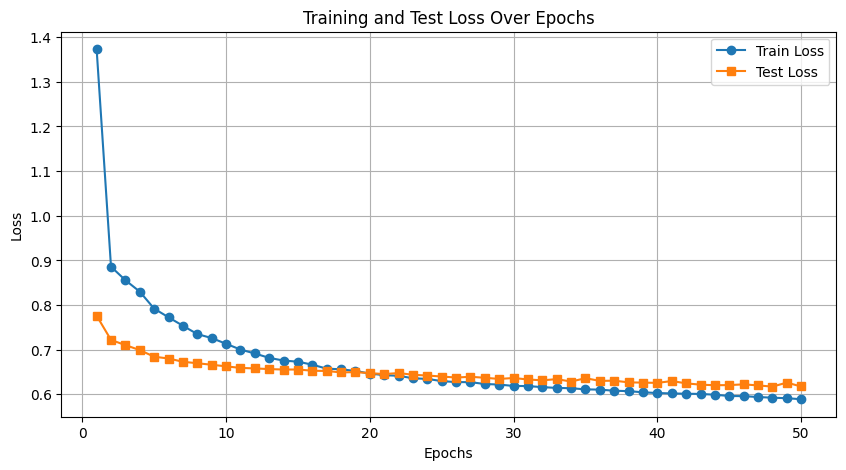

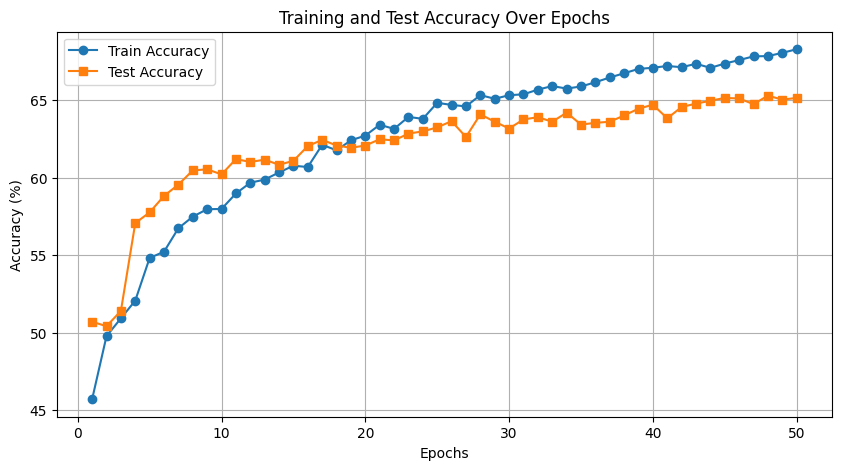

In [14]:
# Plot training and test losses
plt.figure(figsize=(10, 5))
plt.plot(range(1, n_epochs + 1), train_losses, label="Train Loss", marker="o")
plt.plot(range(1, n_epochs + 1), test_losses, label="Test Loss", marker="s")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Test Loss Over Epochs")
plt.legend()
plt.grid(True)
plt.show()

# Plot training and test accuracies
plt.figure(figsize=(10, 5))
plt.plot(range(1, n_epochs + 1), train_accuracies, label="Train Accuracy", marker="o")
plt.plot(range(1, n_epochs + 1), test_accuracies, label="Test Accuracy", marker="s")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.title("Training and Test Accuracy Over Epochs")
plt.legend()
plt.grid(True)
plt.show()